In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
from sklearn import preprocessing
from matplotlib import style
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
temperature_df = pd.read_csv('/content/drive/My Drive/Data mining/GlobalLandTemperaturesByState.csv')
unemployment_df = pd.read_csv('/content/drive/My Drive/Data mining/Unemployment_US.csv')
population_df = pd.read_csv('/content/drive/My Drive/Data mining/population_by_county_1970_to_2018.csv')

In [0]:
columns = ['FIRE_SIZE_CLASS','DISCOVERY_TIME' ,'FIPS_NAME', 'SOURCE_SYSTEM_TYPE','OWNER_DESCR','FIRE_YEAR','STAT_CAUSE_DESCR','LATITUDE','LONGITUDE', 'STATE','DISCOVERY_DATE','FIRE_SIZE']
org_fire = fire_df = pd.read_csv('/content/drive/My Drive/Data mining/CaliforniaWildfiresFIPS.csv', usecols=columns);


In [0]:
# Changing Discovery_Date format, feature extracting day of week and month from DISCOVERY_DATE
fire_df['DATE'] = pd.to_datetime(fire_df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
fire_df['MONTH'] = pd.DatetimeIndex(fire_df['DATE']).month
fire_df['DAY_OF_WEEK'] = fire_df['DATE'].dt.weekday_name

In [28]:
fire_df.shape

(189288, 15)

In [29]:
fire_df.describe(include='all')

,SOURCE_SYSTEM_TYPE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_TIME,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,DATE,MONTH,DAY_OF_WEEK
count,189288,189288.000000,1.892880e+05,109968.000000,189288,189288.000000,189288,189288.000000,189288.000000,189288,189288,189288,189288,189288.000000,189288
unique,3,NaN,NaN,NaN,13,NaN,7,NaN,NaN,16,1,58,8323,NaN,7
top,NONFED,NaN,NaN,NaN,Miscellaneous,NaN,A,NaN,NaN,MISSING/NOT SPECIFIED,CA,Riverside,2008-06-21 00:00:00,NaN,Saturday
freq,111480,NaN,NaN,NaN,51874,NaN,98159,NaN,NaN,107020,189288,19304,552,NaN,29218
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1992-01-01 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-31 00:00:00,NaN,NaN
mean,NaN,2003.119474,2.452885e+06,1383.725957,NaN,67.268378,NaN,37.433761,-120.182710,NaN,NaN,NaN,NaN,7.138884,NaN
std,NaN,7.006533,2.553976e+03,490.308690,NaN,2031.327210,NaN,2.590694,2.153211,NaN,NaN,NaN,NaN,2.168659,NaN
min,NaN,1992.000000,2.448622e+06,0.000000,NaN,0.001000,NaN,32.537406,-124.402883,NaN,NaN,NaN,NaN,1.000000,NaN
25%,NaN,1997.000000,2.450624e+06,1115.000000,NaN,0.100000,NaN,35.179180,-121.721111,NaN,NaN,NaN,NaN,6.000000,NaN


In [0]:
# getting part of day from discovery time
fire_df['DISCOVERY_TIME'] = pd.to_numeric(fire_df['DISCOVERY_TIME'])
def part_of_day(x):
    return (
        "morning" if 500 <= x < 1200
        else
        "afternoon" if 1200 <= x < 1800
        else
        "evening" if 1800 <= x < 2200
        else
        "night" if 2200<=x or  x<500
        else
        "unknown"
    )
fire_df['PART_OF_DAY'] = fire_df.DISCOVERY_TIME.apply(part_of_day)

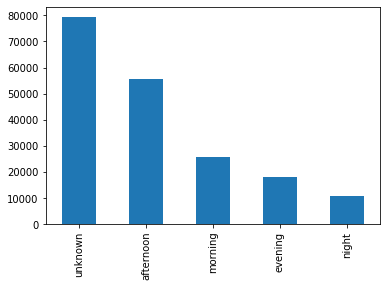

In [31]:
fire_df.PART_OF_DAY.value_counts().plot.bar()

In [0]:
fire_df.drop(['DISCOVERY_TIME'], axis=1, inplace=True)

In [33]:
fire_df.isna().sum()

SOURCE_SYSTEM_TYPE    0
FIRE_YEAR             0
DISCOVERY_DATE        0
STAT_CAUSE_DESCR      0
FIRE_SIZE             0
FIRE_SIZE_CLASS       0
LATITUDE              0
LONGITUDE             0
OWNER_DESCR           0
STATE                 0
FIPS_NAME             0
DATE                  0
MONTH                 0
DAY_OF_WEEK           0
PART_OF_DAY           0
dtype: int64

In [34]:
fire_df.drop_duplicates(keep=False,inplace=True) 
fire_df.shape

(186166, 15)

In [35]:
print(min(fire_df.FIRE_YEAR), max(fire_df.FIRE_YEAR))

1992 2015


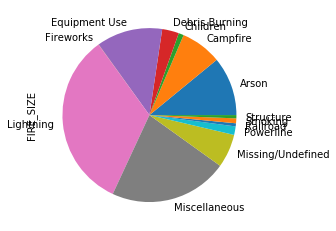

In [36]:
fire_df.groupby('STAT_CAUSE_DESCR').FIRE_SIZE.sum().plot.pie()

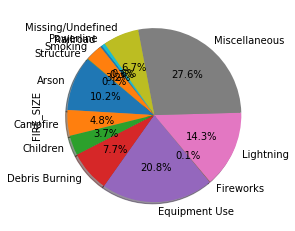

In [37]:
fire_df.groupby('STAT_CAUSE_DESCR').FIRE_SIZE.count().plot.pie(autopct='%1.1f%%', shadow=True, startangle=140)

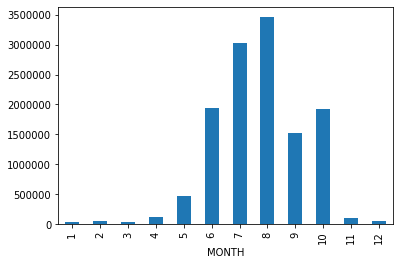

In [38]:
fire_df.groupby('MONTH').FIRE_SIZE.sum().plot.bar()

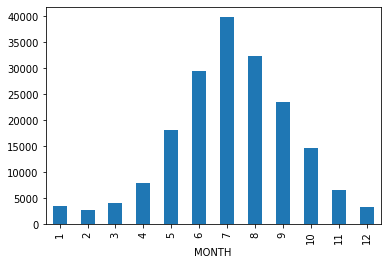

In [39]:
fire_df.groupby('MONTH').FIRE_SIZE.count().plot.bar()

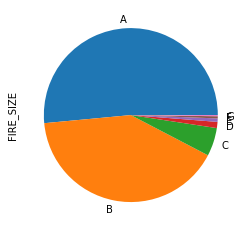

In [40]:
fire_df.groupby('FIRE_SIZE_CLASS').FIRE_SIZE.count().plot.pie()

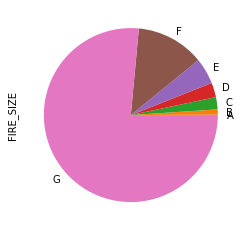

In [41]:
fire_df.groupby('FIRE_SIZE_CLASS').FIRE_SIZE.sum().plot.pie()

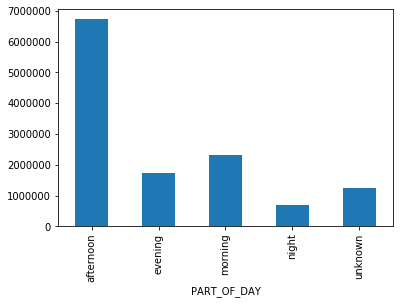

In [42]:
fire_df.groupby('PART_OF_DAY').FIRE_SIZE.sum().plot.bar()

In [0]:
def remove_outliers(norm_num_df,merged_df):

  fire_df_wo_outlier_zscore = norm_num_df[(np.abs(norm_num_df) < 3).all(axis=1)]
  Q1, Q3 = np.percentile(fire_df_wo_outlier_zscore, [25, 75])
  IQR = Q3 - Q1
  idx = ~((fire_df_wo_outlier_zscore < (Q1 - 1.5 * IQR)) | (fire_df_wo_outlier_zscore > (Q3 + 1.5 * IQR))).any(axis=1)
  idx = idx[idx.values == True]
  fire_df_wo_outlier = fire_df_wo_outlier_zscore[fire_df_wo_outlier_zscore.index.isin(idx.index)]
  merged_df = merged_df[merged_df.index.isin(fire_df_wo_outlier.index)]
  return merged_df

In [0]:
def show_outliers(df):
  col_names = df.columns
  if len(col_names) > 1:
    fig, ax = plt.subplots(len(col_names), figsize=(8,40))
    for i, col_val in enumerate(col_names):
        sns.boxplot(y=df[col_val], ax=ax[i])
        ax[i].set_title('Box Plot '+col_val, fontsize=10)
        ax[i].set_xlabel(col_val, fontsize=8)
    plt.show()
  else:
    sns.boxplot(y=df[col_names[0]])

In [0]:
# z-score normalization
def normalizeData(num_df):
  return (num_df - num_df.mean())/num_df.std()

In [0]:
def outliers_iqr(norm_num_df):
    quartile_1, quartile_3 = np.percentile(s, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = (s > upper_bound) | (s < lower_bound)
    norm_num_df.drop(outliers.index,inplace=True)
    return norm_num_df

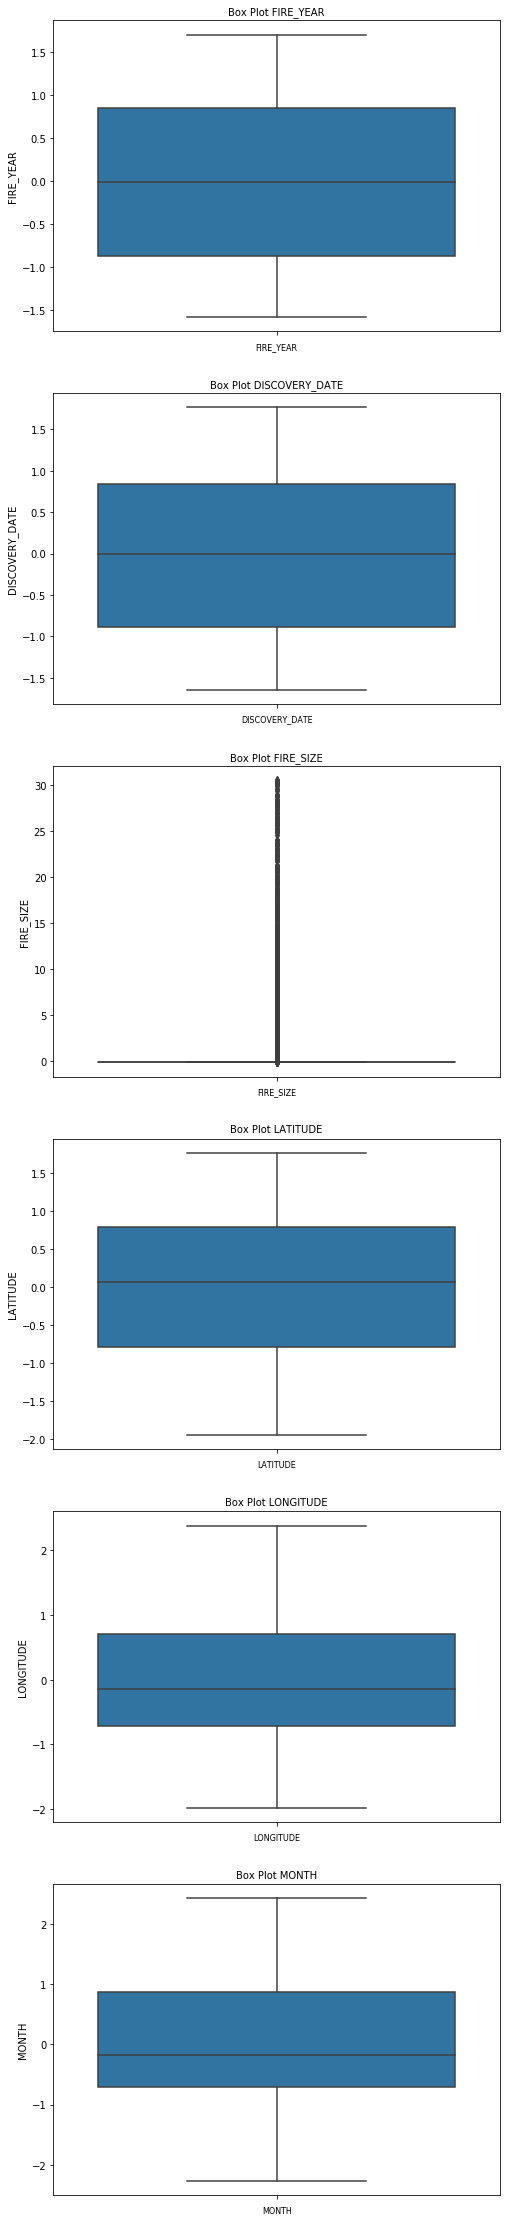

In [47]:
num_df = fire_df.select_dtypes(include='number')
norm_num_df = normalizeData(num_df)
fire_df = remove_outliers(norm_num_df, fire_df)
num_df = fire_df.select_dtypes(include='number')
show_outliers(normalizeData(num_df))

In [0]:
temperature_US_df = temperature_df[temperature_df['Country'] == 'United States']

In [0]:
temperature_US_df.dropna(inplace=True)

In [50]:
temperature_US_df = temperature_US_df.set_index('dt')
temperature_US_df.index =  pd.to_datetime(temperature_US_df.index)
temperature_US_df.head()

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1743-11-01,10.722,2.898,Alabama,United States
1744-04-01,19.075,2.902,Alabama,United States
1744-05-01,21.197,2.844,Alabama,United States
1744-06-01,25.290,2.879,Alabama,United States
1744-07-01,26.420,2.841,Alabama,United States


In [0]:
temperature_US_df = temperature_US_df.loc['1992-01-01':'2015-12-31']

In [0]:
temperature_US_df.drop(['AverageTemperatureUncertainty','Country'], axis = 1,inplace = True)

In [53]:
temperature_US_df.head()

,AverageTemperature,State
dt,,
1992-01-01,6.979,Alabama
1992-02-01,10.898,Alabama
1992-03-01,12.995,Alabama
1992-04-01,16.589,Alabama
1992-05-01,20.430,Alabama


In [54]:
max(temperature_US_df.index)

Timestamp('2013-09-01 00:00:00')

In [0]:
def correctedMonth(x):
    year,month = x.split('-');
    if len(month) < 2:
        month = '0'+month
    return year + '-'+month

In [0]:
temperature_US_df['joinColumn'] = temperature_US_df.index.year.map(str) + '-' +  temperature_US_df.index.month.map(str)

In [57]:
temperature_US_df.head()

,AverageTemperature,State,joinColumn
dt,,,
1992-01-01,6.979,Alabama,1992-1
1992-02-01,10.898,Alabama,1992-2
1992-03-01,12.995,Alabama,1992-3
1992-04-01,16.589,Alabama,1992-4
1992-05-01,20.430,Alabama,1992-5


In [0]:
temperature_US_df.joinColumn = temperature_US_df.joinColumn.apply(correctedMonth)

In [0]:
temperature_US_df = temperature_US_df[temperature_US_df.State == 'California']

In [0]:
fire_df['dt'] = fire_df.FIRE_YEAR.map(str) + '-' + fire_df.MONTH.map(str) 

In [0]:
fire_df.dt = fire_df.dt.apply(correctedMonth)

In [62]:
temperature_US_df.isna().sum()

AverageTemperature    0
State                 0
joinColumn            0
dtype: int64

In [0]:
merged_df = fire_df.merge(temperature_US_df,left_on=['dt'], right_on=['joinColumn'],how='left')

In [0]:
merged_df.drop(['State', 'joinColumn'], axis=1, inplace=True)

In [65]:
merged_df.isna().sum()

SOURCE_SYSTEM_TYPE        0
FIRE_YEAR                 0
DISCOVERY_DATE            0
STAT_CAUSE_DESCR          0
FIRE_SIZE                 0
FIRE_SIZE_CLASS           0
LATITUDE                  0
LONGITUDE                 0
OWNER_DESCR               0
STATE                     0
FIPS_NAME                 0
DATE                      0
MONTH                     0
DAY_OF_WEEK               0
PART_OF_DAY               0
dt                        0
AverageTemperature    14078
dtype: int64

In [0]:
merged_bk = merged_df.copy()

In [0]:
merged_df = merged_bk.copy()

In [0]:
# Fill out missing temperature value by mean values of that year
merged_df["AverageTemperature"] = merged_df.groupby("FIRE_YEAR")['AverageTemperature'].transform(lambda x: x.fillna(x.mean()))

In [0]:
# forward fill of missing values
merged_df.AverageTemperature.fillna(method='pad', inplace =True)

In [70]:
merged_df.head()

,SOURCE_SYSTEM_TYPE,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,DATE,MONTH,DAY_OF_WEEK,PART_OF_DAY,dt,AverageTemperature
0,FED,2004,2453137.5,Lightning,0.25,A,38.933056,-120.404444,USFS,CA,El Dorado,2004-05-12,5,Wednesday,morning,2004-05,17.627
1,FED,2004,2453156.5,Debris Burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,El Dorado,2004-05-31,5,Monday,evening,2004-05,17.627
2,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.913333,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407
3,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.933056,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407
4,FED,2004,2453186.5,Lightning,0.10,A,38.635278,-120.103611,USFS,CA,Amador,2004-06-30,6,Wednesday,evening,2004-06,21.407


In [71]:
unemployment_df.head()

,Year,Month,State,County,Rate
0,2015,February,Mississippi,Newton County,6.1
1,2015,February,Mississippi,Panola County,9.4
2,2015,February,Mississippi,Monroe County,7.9
3,2015,February,Mississippi,Hinds County,6.1
4,2015,February,Mississippi,Kemper County,10.6


In [0]:
unemployment_df = unemployment_df[unemployment_df.State == 'California']

In [0]:
unemployment_df.Month = pd.to_datetime(unemployment_df.Month.str[0:3], format='%b').dt.month

In [0]:
unemployment_df['joinColumn'] = unemployment_df.Year.map(str) + '-' + unemployment_df.Month.map(str)

In [0]:
unemployment_df.County = unemployment_df.County.str.split(' County').str[0]

In [0]:
unemployment_df.joinColumn = unemployment_df.joinColumn.apply(correctedMonth)

In [0]:
unemployment_df.joinColumn = unemployment_df.joinColumn + unemployment_df.County

In [0]:
merged_df['joinColumn'] = merged_df.dt + merged_df.FIPS_NAME

In [79]:
merged_df.head()

,SOURCE_SYSTEM_TYPE,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,DATE,MONTH,DAY_OF_WEEK,PART_OF_DAY,dt,AverageTemperature,joinColumn
0,FED,2004,2453137.5,Lightning,0.25,A,38.933056,-120.404444,USFS,CA,El Dorado,2004-05-12,5,Wednesday,morning,2004-05,17.627,2004-05El Dorado
1,FED,2004,2453156.5,Debris Burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,El Dorado,2004-05-31,5,Monday,evening,2004-05,17.627,2004-05El Dorado
2,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.913333,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,2004-06Alpine
3,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.933056,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,2004-06Alpine
4,FED,2004,2453186.5,Lightning,0.10,A,38.635278,-120.103611,USFS,CA,Amador,2004-06-30,6,Wednesday,evening,2004-06,21.407,2004-06Amador


In [0]:
merged_df = merged_df.merge(unemployment_df, on='joinColumn', how='left')

In [81]:
merged_df.head()

,SOURCE_SYSTEM_TYPE,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,DATE,MONTH,DAY_OF_WEEK,PART_OF_DAY,dt,AverageTemperature,joinColumn,Year,Month,State,County,Rate
0,FED,2004,2453137.5,Lightning,0.25,A,38.933056,-120.404444,USFS,CA,El Dorado,2004-05-12,5,Wednesday,morning,2004-05,17.627,2004-05El Dorado,2004.0,5.0,California,El Dorado,5.2
1,FED,2004,2453156.5,Debris Burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,El Dorado,2004-05-31,5,Monday,evening,2004-05,17.627,2004-05El Dorado,2004.0,5.0,California,El Dorado,5.2
2,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.913333,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,2004-06Alpine,2004.0,6.0,California,Alpine,11.1
3,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.933056,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,2004-06Alpine,2004.0,6.0,California,Alpine,11.1
4,FED,2004,2453186.5,Lightning,0.10,A,38.635278,-120.103611,USFS,CA,Amador,2004-06-30,6,Wednesday,evening,2004-06,21.407,2004-06Amador,2004.0,6.0,California,Amador,5.9


In [0]:
merged_df.drop(['Year','Month',	'State',	'County','joinColumn'],axis = 1, inplace= True)

In [83]:
merged_df[merged_df.Rate.isna()]

,SOURCE_SYSTEM_TYPE,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,DATE,MONTH,DAY_OF_WEEK,PART_OF_DAY,dt,AverageTemperature,Rate
61833,NONFED,2010,2455422.5,Miscellaneous,0.10,A,36.896111,-121.426944,MISSING/NOT SPECIFIED,CA,San Benito,2010-08-14,8,Saturday,unknown,2010-08,22.987000,NaN
61834,NONFED,2010,2455439.5,Equipment Use,0.30,B,36.826944,-121.381944,MISSING/NOT SPECIFIED,CA,San Benito,2010-08-31,8,Tuesday,unknown,2010-08,22.987000,NaN
65292,NONFED,2010,2455288.5,Debris Burning,0.10,A,36.971944,-120.608889,MISSING/NOT SPECIFIED,CA,Merced,2010-04-02,4,Friday,unknown,2010-04,10.878000,NaN
65293,NONFED,2010,2455302.5,Miscellaneous,0.10,A,36.708056,-119.663889,MISSING/NOT SPECIFIED,CA,Fresno,2010-04-16,4,Friday,unknown,2010-04,10.878000,NaN
65361,NONFED,2010,2455304.5,Miscellaneous,0.10,A,36.713056,-119.760000,MISSING/NOT SPECIFIED,CA,Fresno,2010-04-18,4,Sunday,unknown,2010-04,10.878000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178253,NONFED,2010,2455412.5,Missing/Undefined,0.50,B,41.530567,-120.523647,STATE OR PRIVATE,CA,Modoc,2010-08-04,8,Wednesday,afternoon,2010-08,22.987000,NaN
178267,NONFED,2012,2456157.5,Miscellaneous,1.00,B,41.077600,-121.583650,MISSING/NOT SPECIFIED,CA,Shasta,2012-08-18,8,Saturday,morning,2012-08,25.407000,NaN
178278,NONFED,2010,2455409.5,Equipment Use,2.10,B,40.555183,-124.136117,STATE OR PRIVATE,CA,Humboldt,2010-08-01,8,Sunday,afternoon,2010-08,22.987000,NaN
178284,NONFED,2013,2456402.5,Children,4.50,B,34.633333,-118.966666,MISSING/NOT SPECIFIED,CA,Ventura,2013-04-20,4,Saturday,afternoon,2013-04,14.707000,NaN


In [0]:
merged_df["Rate"] = merged_df.groupby("FIRE_YEAR")['Rate'].transform(lambda x: x.fillna(x.mean()))

In [0]:
merged_bk = merged_df.copy()

In [86]:
population_df.head()

,County,Year,Population
0,Alameda,1970,"1,071,446"
1,Alpine,1970,484
2,Amador,1970,"11,821"
3,Butte,1970,"101,969"
4,Calaveras,1970,"13,585"


In [0]:
population_df['joinColumn'] = population_df.Year.map(str) + population_df.County

In [88]:
merged_df.head()

,SOURCE_SYSTEM_TYPE,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,DATE,MONTH,DAY_OF_WEEK,PART_OF_DAY,dt,AverageTemperature,Rate
0,FED,2004,2453137.5,Lightning,0.25,A,38.933056,-120.404444,USFS,CA,El Dorado,2004-05-12,5,Wednesday,morning,2004-05,17.627,5.2
1,FED,2004,2453156.5,Debris Burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,El Dorado,2004-05-31,5,Monday,evening,2004-05,17.627,5.2
2,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.913333,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,11.1
3,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.933056,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,11.1
4,FED,2004,2453186.5,Lightning,0.10,A,38.635278,-120.103611,USFS,CA,Amador,2004-06-30,6,Wednesday,evening,2004-06,21.407,5.9


In [0]:
merged_df['joinColumn'] = merged_df.FIRE_YEAR.map(str) + merged_df.FIPS_NAME

In [0]:
merged_df = merged_df.merge(population_df, on='joinColumn', how='left')

In [0]:
merged_df.drop(['joinColumn', 'County',	'Year'], axis=1, inplace=True)

In [92]:
merged_df.head()

,SOURCE_SYSTEM_TYPE,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,DATE,MONTH,DAY_OF_WEEK,PART_OF_DAY,dt,AverageTemperature,Rate,Population
0,FED,2004,2453137.5,Lightning,0.25,A,38.933056,-120.404444,USFS,CA,El Dorado,2004-05-12,5,Wednesday,morning,2004-05,17.627,5.2,"168,984"
1,FED,2004,2453156.5,Debris Burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,El Dorado,2004-05-31,5,Monday,evening,2004-05,17.627,5.2,"168,984"
2,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.913333,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,11.1,"1,257"
3,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.933056,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,11.1,"1,257"
4,FED,2004,2453186.5,Lightning,0.10,A,38.635278,-120.103611,USFS,CA,Amador,2004-06-30,6,Wednesday,evening,2004-06,21.407,5.9,"36,961"


In [0]:
merged_df.Population = pd.to_numeric(merged_df.Population.str.replace(',', ''))

In [94]:
merged_df.head()

,SOURCE_SYSTEM_TYPE,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,DATE,MONTH,DAY_OF_WEEK,PART_OF_DAY,dt,AverageTemperature,Rate,Population
0,FED,2004,2453137.5,Lightning,0.25,A,38.933056,-120.404444,USFS,CA,El Dorado,2004-05-12,5,Wednesday,morning,2004-05,17.627,5.2,168984
1,FED,2004,2453156.5,Debris Burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,El Dorado,2004-05-31,5,Monday,evening,2004-05,17.627,5.2,168984
2,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.913333,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,11.1,1257
3,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.933056,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,11.1,1257
4,FED,2004,2453186.5,Lightning,0.10,A,38.635278,-120.103611,USFS,CA,Amador,2004-06-30,6,Wednesday,evening,2004-06,21.407,5.9,36961


In [95]:
merged_df.isna().sum()

SOURCE_SYSTEM_TYPE    0
FIRE_YEAR             0
DISCOVERY_DATE        0
STAT_CAUSE_DESCR      0
FIRE_SIZE             0
FIRE_SIZE_CLASS       0
LATITUDE              0
LONGITUDE             0
OWNER_DESCR           0
STATE                 0
FIPS_NAME             0
DATE                  0
MONTH                 0
DAY_OF_WEEK           0
PART_OF_DAY           0
dt                    0
AverageTemperature    0
Rate                  0
Population            0
dtype: int64

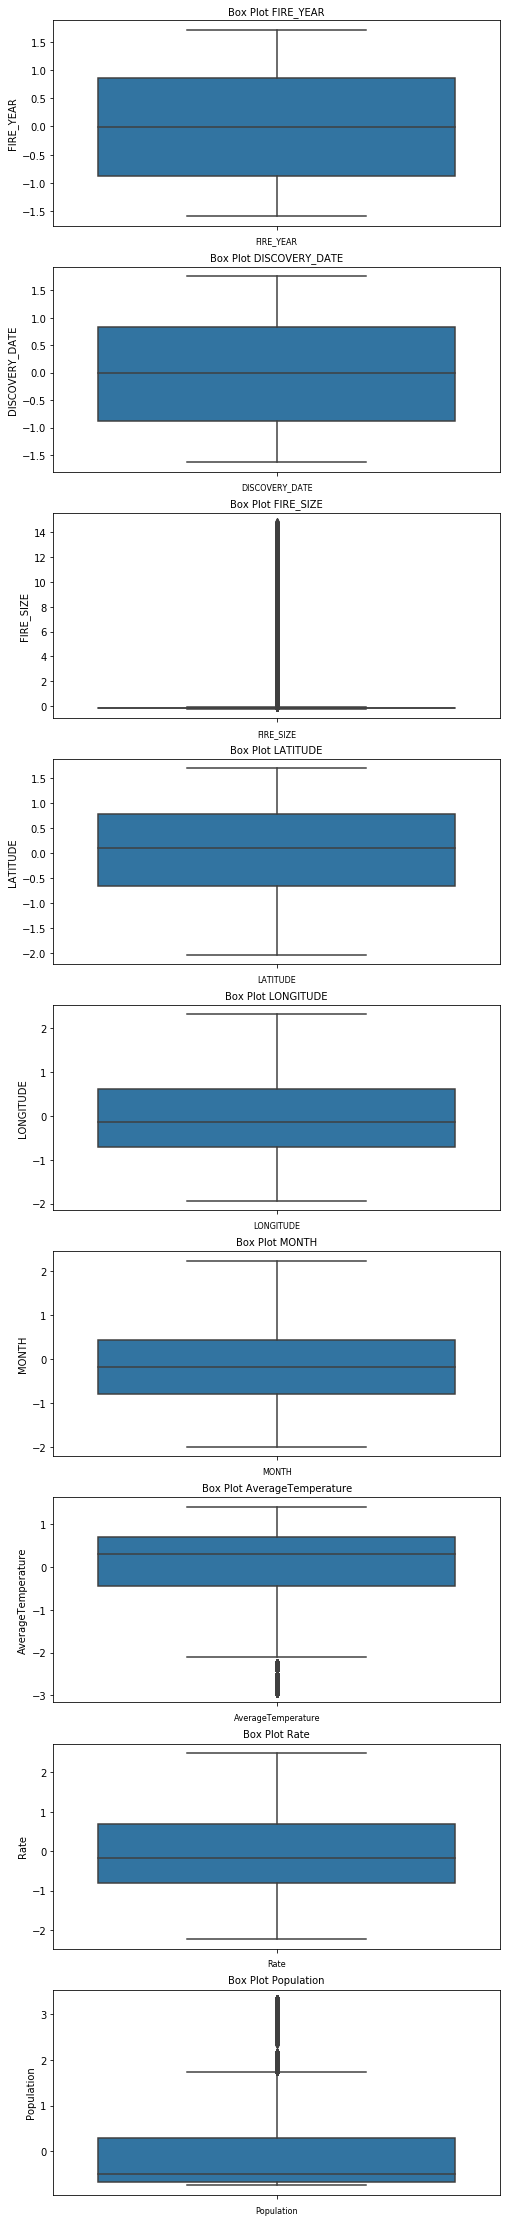

In [96]:
num_df = merged_df.select_dtypes(include='number')
norm_num_df = normalizeData(num_df)
merged_df = remove_outliers(norm_num_df, merged_df)
num_df = merged_df.select_dtypes(include='number')
show_outliers(normalizeData(num_df))

In [97]:
merged_df.shape

(157360, 19)

In [0]:
merged_bk = merged_df.copy()
le = preprocessing.LabelEncoder()
merged_df['STAT_CAUSE_DESCR_CODE'] = le.fit_transform(merged_df['STAT_CAUSE_DESCR'])
merged_df['DAY_OF_WEEK_CODE'] = le.fit_transform(merged_df['DAY_OF_WEEK'])
merged_df['SOURCE_SYSTEM_TYPE_CODE'] = le.fit_transform(merged_df['SOURCE_SYSTEM_TYPE'])
merged_df['FIRE_SIZE_CLASS_CODE'] = le.fit_transform(merged_df['FIRE_SIZE_CLASS'])
merged_df['OWNER_DESCR_CODE'] = le.fit_transform(merged_df['OWNER_DESCR'])
merged_df['FIPS_NAME_CODE'] = le.fit_transform(merged_df['FIPS_NAME'])
merged_df['PART_OF_DAY_CODE'] = le.fit_transform(merged_df['PART_OF_DAY'])

In [99]:
merged_df.FIRE_SIZE_CLASS.value_counts()

A    80328
B    66169
C     8703
D     1890
E      270
Name: FIRE_SIZE_CLASS, dtype: int64

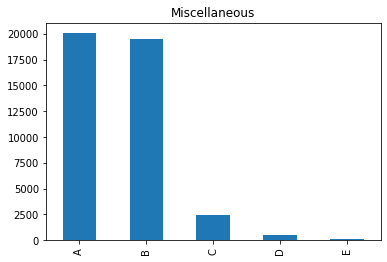

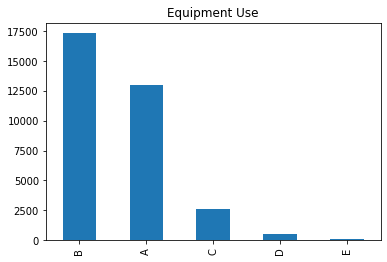

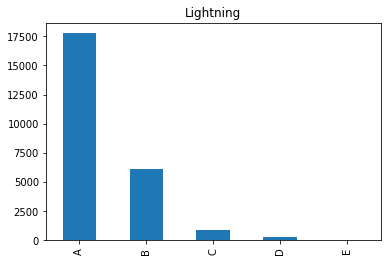

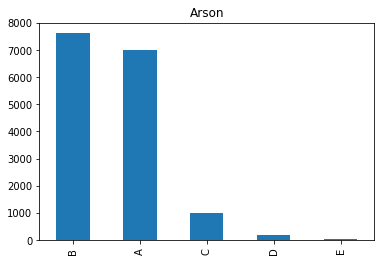

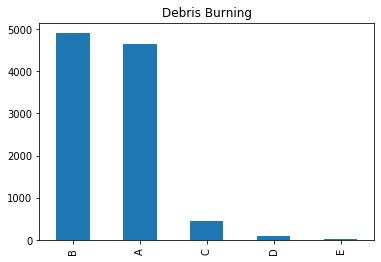

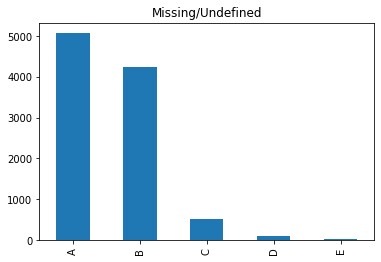

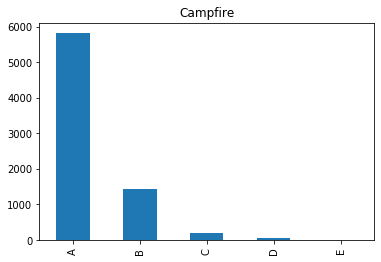

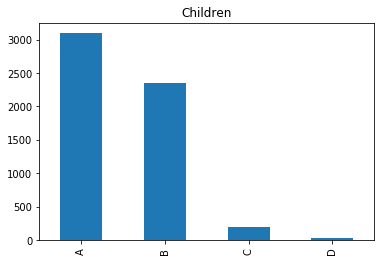

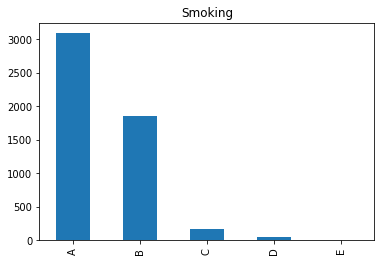

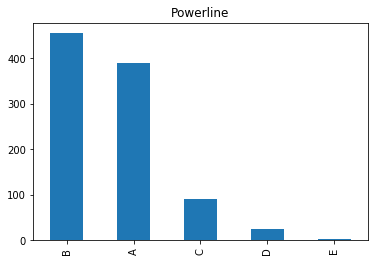

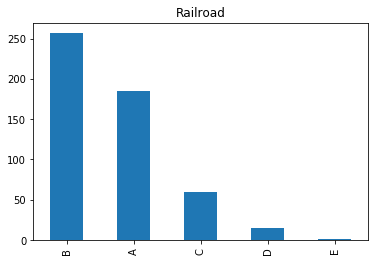

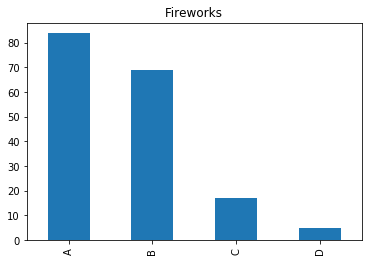

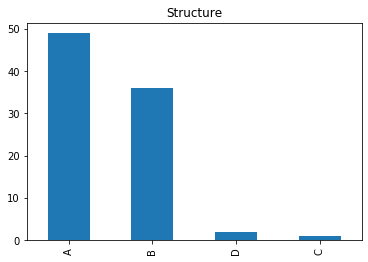

In [100]:
for v, count in merged_df.STAT_CAUSE_DESCR.value_counts().iteritems():
  merged_df[merged_df.STAT_CAUSE_DESCR == v].FIRE_SIZE_CLASS.value_counts().plot.bar()
  plt.title(v)
  plt.show()  

In [101]:
merged_df.FIRE_SIZE_CLASS_CODE.value_counts()

0    80328
1    66169
2     8703
3     1890
4      270
Name: FIRE_SIZE_CLASS_CODE, dtype: int64

In [102]:
merged_df.head()

,SOURCE_SYSTEM_TYPE,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_NAME,DATE,MONTH,DAY_OF_WEEK,PART_OF_DAY,dt,AverageTemperature,Rate,Population,STAT_CAUSE_DESCR_CODE,DAY_OF_WEEK_CODE,SOURCE_SYSTEM_TYPE_CODE,FIRE_SIZE_CLASS_CODE,OWNER_DESCR_CODE,FIPS_NAME_CODE,PART_OF_DAY_CODE
0,FED,2004,2453137.5,Lightning,0.25,A,38.933056,-120.404444,USFS,CA,El Dorado,2004-05-12,5,Wednesday,morning,2004-05,17.627,5.2,168984,6,6,0,0,15,8,2
1,FED,2004,2453156.5,Debris Burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,El Dorado,2004-05-31,5,Monday,evening,2004-05,17.627,5.2,168984,3,1,0,0,12,8,1
2,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.913333,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,11.1,1257,6,1,0,0,15,1,0
3,FED,2004,2453184.5,Lightning,0.10,A,38.559167,-119.933056,USFS,CA,Alpine,2004-06-28,6,Monday,afternoon,2004-06,21.407,11.1,1257,6,1,0,0,15,1,0
4,FED,2004,2453186.5,Lightning,0.10,A,38.635278,-120.103611,USFS,CA,Amador,2004-06-30,6,Wednesday,evening,2004-06,21.407,5.9,36961,6,6,0,0,15,2,1


In [0]:
num_df = merged_df.select_dtypes(include=["number"])

In [0]:
from sklearn.preprocessing import MinMaxScaler

def normalizeMinMax(num_df, maxv):
  x = num_df.values 
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,maxv))
  x_scaled = min_max_scaler.fit_transform(x)
  num_df = pd.DataFrame(x_scaled,columns=num_df.columns)
  return num_df

In [0]:
num_bk = num_df.copy()
# num_df = num_df[num_df.FIRE_SIZE_CLASS_CODE.isin([0,1])]

In [0]:
merged_df.drop(['DISCOVERY_DATE', 'SOURCE_SYSTEM_TYPE_CODE', 'FIPS_NAME_CODE', 'FIRE_YEAR' ], axis=1, inplace=True)

In [0]:
def dropColumns(df, n):
  num_df= df.select_dtypes(include='number')
  num_df.drop(['FIRE_SIZE', 'OWNER_DESCR_CODE', 'DAY_OF_WEEK_CODE', 'Rate'],axis=1,inplace=True)
  # num_df = normalizeMinMax(num_df, n-1)
  return num_df, num_df.drop('FIRE_SIZE_CLASS_CODE', axis=1).columns

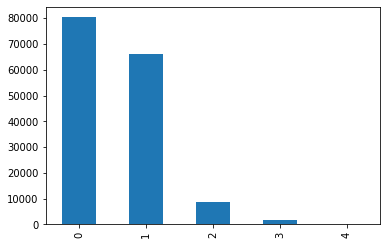

In [108]:
merged_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()

# SMOTE SAMPLING (Sampling all data) for 5 Class Labels


(157360, 7) (157360,)


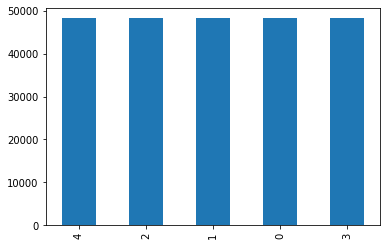

In [109]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
n = 5
num_df = merged_df.select_dtypes(include=["number"])
num_df, iv = dropColumns(num_df,n)

org_y = y = num_df.FIRE_SIZE_CLASS_CODE # Dependent Variable
org_X = X = num_df.drop('FIRE_SIZE_CLASS_CODE', axis=1) # Independent Variable

print(X.shape, y.shape)

smote = SMOTE()

# # Oversampling minority classes
X1, y1 = smote.fit_resample(X, y) 


# Holdup Method for Splitting training and test data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.40, random_state=27,stratify=y1)

# Create an ADASYN instance
# adasyn = ADASYN()

# Oversampling minority classes
# X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train) 

# rus = RandomUnderSampler(random_state=42)
# X_train, y_train = rus.fit_resample(X_train, y_train)
# X_res_df = pd.DataFrame(X_train, columns=X.columns)
# y_res_df = pd.DataFrame(y_train, columns=['FIRE_SIZE_CLASS_CODE'])
# y_res_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()

X_df = pd.DataFrame(X_train, columns=iv)
y_df = pd.DataFrame(y_train, columns=['FIRE_SIZE_CLASS_CODE'])
X_df.MONTH = round(X_df.MONTH)
X_df.STAT_CAUSE_DESCR_CODE = round(X_df.STAT_CAUSE_DESCR_CODE)
X_df.PART_OF_DAY_CODE = round(X_df.PART_OF_DAY_CODE)


Xt_df = pd.DataFrame(X_test, columns=X.columns)
yt_df = pd.DataFrame(y_test, columns=['FIRE_SIZE_CLASS_CODE'])


# # a = pd.concat([X_train_df, y_train_df], axis=1)
# # y_train_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()

# X_train = X_df.to_numpy()
# pd.concat([X_df, y_df], axis=1).to_csv('train.csv')
# pd.concat([Xt_df, yt_df], axis=1).to_csv('test.csv')

X_train_df = pd.DataFrame(X_train, columns=X.columns)
y_train_df = pd.DataFrame(y_train, columns=['FIRE_SIZE_CLASS_CODE'])
a = pd.concat([X_train_df, y_train_df], axis=1)
b = pd.concat([Xt_df, yt_df], axis=1)

a.to_csv('train.csv')
b.to_csv('test.csv')

y_train_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()

In [0]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.tree.export import export_text
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

def KfoldModel(modelFunction, split, X, y):
  kf = StratifiedKFold(n_splits=split, random_state=None, shuffle=False)
  totalScore = 0
  i = 1
  for train, test in kf.split(X, y):
    train_x_fold, test_x_fold = X[train], X[test]
    train_y_fold, test_y_fold = y[train], y[test]
    print(f'Iteration {i}')
    i+=1
    totalScore += modelFunction(train_x_fold, test_x_fold, train_y_fold, test_y_fold)
  print(totalScore/5)

def decisionTree(X_train, X_test, y_train, y_test, weight=None):
  model = DecisionTreeClassifier(random_state=0, class_weight=weight)
  decisionTree = model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = model.score(X_test, y_test)
  print(f'Accuracy: {score}')
  # print(f'Recall: {recall_score(y_test, y_pred)}')
  print(metrics.classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
  plt.show()
  r = export_text(decisionTree, feature_names=X.columns.to_list())
  # print(r)
  # scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
  # print(scores)
  return score

def Naive_bayes(X_train, X_test, y_train, y_test):
  NB = MultinomialNB().fit(X_train, y_train)
  y_pred = NB.predict(X_test)
  score = NB.score(X_test, y_test)
  print(f'Testing Accuracy: {score}')
  print(metrics.classification_report( y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
  return score

def knn(X_train, X_test, y_train, y_test):
  knn = KNeighborsClassifier().fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  score = knn.score(X_test, y_test)
  print(f'Testing Accuracy: {score}')
  print(metrics.classification_report( y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
  return score

  
def randomForest(X_train, X_test, y_train, y_test, iv, weight=None):
  # class_weight = dict({1:1.9, 2:35, 3:180})
  rf = RandomForestClassifier(
            class_weight=weight
            ) 
  model = rf.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = model.score(X_test, y_test)
  print(f'Accuracy: {score}')
  # print(f'Recall: {recall_score(y_test, y_pred)}')
  print(metrics.classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
  plt.show()
  feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index =iv,
                                    columns=['importance']).sort_values('importance', ascending=False)
  print(feature_importances)
  return score

Accuracy: 0.7170974006573051
              precision    recall  f1-score   support

           0       0.56      0.54      0.55     32131
           1       0.51      0.50      0.51     32131
           2       0.71      0.71      0.71     32131
           3       0.84      0.86      0.85     32132
           4       0.96      0.97      0.97     32131

    accuracy                           0.72    160656
   macro avg       0.71      0.72      0.72    160656
weighted avg       0.71      0.72      0.72    160656



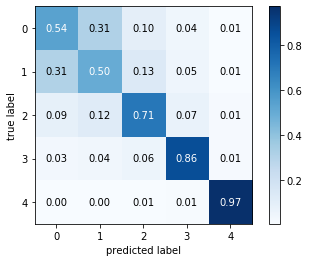

0.7170974006573051

In [111]:
decisionTree(X_train, X_test, y_train, y_test)

Accuracy: 0.7706465989443283
              precision    recall  f1-score   support

           0       0.60      0.64      0.62     32131
           1       0.58      0.53      0.55     32131
           2       0.79      0.77      0.78     32131
           3       0.90      0.92      0.91     32132
           4       0.98      0.99      0.99     32131

    accuracy                           0.77    160656
   macro avg       0.77      0.77      0.77    160656
weighted avg       0.77      0.77      0.77    160656



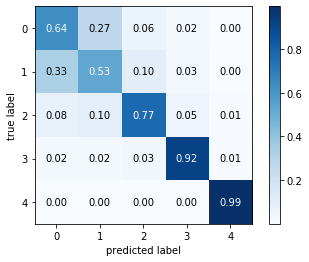

                       importance
Population               0.220736
LATITUDE                 0.219347
LONGITUDE                0.212393
AverageTemperature       0.165086
STAT_CAUSE_DESCR_CODE    0.076080
MONTH                    0.060379
PART_OF_DAY_CODE         0.045979


0.7706465989443283

In [112]:
randomForest(X_train, X_test, y_train, y_test, iv)

# SMOTE SAMPLING (Sampling only training data) for 5 Class Labels

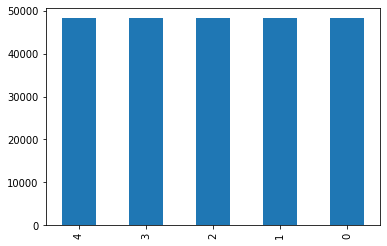

In [113]:
num_df = merged_df.select_dtypes(include=["number"])
n =5
num_df, iv = dropColumns(num_df, n)

org_y = y = num_df.FIRE_SIZE_CLASS_CODE # Dependent Variable
org_X = X = num_df.drop('FIRE_SIZE_CLASS_CODE', axis=1) # Independent Variable

smote = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0,stratify=y)
X_train, y_train = smote.fit_sample(X_train, y_train)

X_df = pd.DataFrame(X_train, columns=org_X.columns)
y_df = pd.DataFrame(y_train, columns=['FIRE_SIZE_CLASS_CODE'])
X_df.MONTH = round(X_df.MONTH)
X_df.STAT_CAUSE_DESCR_CODE = round(X_df.STAT_CAUSE_DESCR_CODE)
# X_df.DAY_OF_WEEK_CODE = round(X_df.DAY_OF_WEEK_CODE)
# X_df.OWNER_DESCR_CODE = round(X_df.OWNER_DESCR_CODE)
X_df.PART_OF_DAY_CODE = round(X_df.PART_OF_DAY_CODE)


Xt_df = pd.DataFrame(X_test, columns=X.columns)
yt_df = pd.DataFrame(y_test, columns=['FIRE_SIZE_CLASS_CODE'])


# # a = pd.concat([X_train_df, y_train_df], axis=1)
# # y_train_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()

# X_train = X_df.to_numpy()
# pd.concat([X_df, y_df], axis=1).to_csv('train.csv')
# pd.concat([Xt_df, yt_df], axis=1).to_csv('test.csv')

X_train_df = pd.DataFrame(X_train, columns=X.columns)
y_train_df = pd.DataFrame(y_train, columns=['FIRE_SIZE_CLASS_CODE'])
a = pd.concat([X_train_df, y_train_df], axis=1)
b = pd.concat([Xt_df, yt_df], axis=1)

a.to_csv('train.csv')
b.to_csv('test.csv')

y_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()

Accuracy: 0.4962665226232842
              precision    recall  f1-score   support

           0       0.62      0.56      0.59     32131
           1       0.51      0.47      0.49     26468
           2       0.10      0.19      0.13      3481
           3       0.03      0.08      0.04       756
           4       0.01      0.02      0.01       108

    accuracy                           0.50     62944
   macro avg       0.25      0.26      0.25     62944
weighted avg       0.54      0.50      0.51     62944



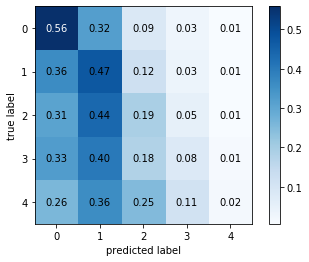

0.4962665226232842

In [114]:
decisionTree(X_train, X_test, y_train, y_test)

Accuracy: 0.548741738688358
              precision    recall  f1-score   support

           0       0.64      0.65      0.64     32131
           1       0.55      0.49      0.52     26468
           2       0.12      0.17      0.14      3481
           3       0.04      0.07      0.05       756
           4       0.02      0.03      0.02       108

    accuracy                           0.55     62944
   macro avg       0.27      0.28      0.27     62944
weighted avg       0.56      0.55      0.56     62944



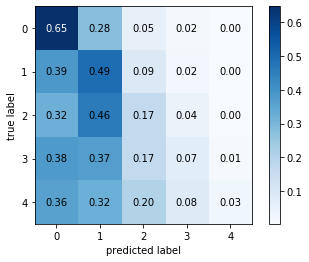

                       importance
Population               0.229465
LATITUDE                 0.214971
LONGITUDE                0.207238
AverageTemperature       0.167074
STAT_CAUSE_DESCR_CODE    0.073562
MONTH                    0.061015
PART_OF_DAY_CODE         0.046676


0.548741738688358

In [115]:
randomForest(X_train, X_test, y_train, y_test, iv)

# Sampling after splitting for reduced Class Labels to 3

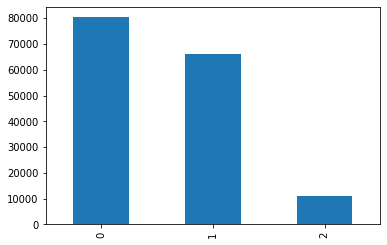

In [116]:
def modified_fire_class(x, n):
  if x in range(n,7):
    return n-1
  else:
    return x
n = 3
num_df = merged_df.select_dtypes(include=["number"])
num_df.FIRE_SIZE_CLASS_CODE = num_df.FIRE_SIZE_CLASS_CODE.apply(modified_fire_class, n=n)
num_df, iv = dropColumns(num_df, n)
num_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()

(144591, 7) (62944, 7)


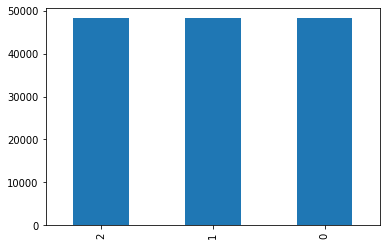

In [117]:
y = num_df.FIRE_SIZE_CLASS_CODE # Dependent Variable
X = num_df.drop('FIRE_SIZE_CLASS_CODE', axis=1) # Independent Variable

smote = SMOTE()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,stratify=y)

X_train, y_train = smote.fit_resample(X_train, y_train)
print(X_train.shape, X_test.shape)
X_df = pd.DataFrame(X_train, columns= num_df.drop('FIRE_SIZE_CLASS_CODE', axis=1).columns)
y_df = pd.DataFrame(y_train, columns=['FIRE_SIZE_CLASS_CODE'])

X_df.MONTH = round(X_df.MONTH)
X_df.STAT_CAUSE_DESCR_CODE = round(X_df.STAT_CAUSE_DESCR_CODE)
# X_df.DAY_OF_WEEK_CODE = round(X_df.DAY_OF_WEEK_CODE)
# X_df.OWNER_DESCR_CODE = round(X_df.OWNER_DESCR_CODE)
X_df.PART_OF_DAY_CODE = round(X_df.PART_OF_DAY_CODE)


Xt_df = pd.DataFrame(X_test, columns=X.columns)
yt_df = pd.DataFrame(y_test, columns=['FIRE_SIZE_CLASS_CODE'])


# # a = pd.concat([X_train_df, y_train_df], axis=1)
# # y_train_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()

# X_train = X_df.to_numpy()
# pd.concat([X_df, y_df], axis=1).to_csv('train.csv')
# pd.concat([Xt_df, yt_df], axis=1).to_csv('test.csv')

X_train_df = pd.DataFrame(X_train, columns=X.columns)
y_train_df = pd.DataFrame(y_train, columns=['FIRE_SIZE_CLASS_CODE'])
a = pd.concat([X_train_df, y_train_df], axis=1)
b = pd.concat([Xt_df, yt_df], axis=1)

a.to_csv('train3.csv')
b.to_csv('test3.csv')

y_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()

Accuracy: 0.5092780884595831
              precision    recall  f1-score   support

           0       0.62      0.57      0.59     32131
           1       0.50      0.48      0.49     26468
           2       0.13      0.23      0.16      4345

    accuracy                           0.51     62944
   macro avg       0.42      0.43      0.42     62944
weighted avg       0.54      0.51      0.52     62944



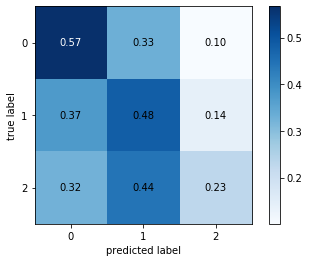

0.5092780884595831

In [118]:
decisionTree(X_train,X_test,y_train,y_test)

Accuracy: 0.5593225724453482
              precision    recall  f1-score   support

           0       0.64      0.65      0.65     32131
           1       0.54      0.50      0.52     26468
           2       0.16      0.21      0.18      4345

    accuracy                           0.56     62944
   macro avg       0.45      0.45      0.45     62944
weighted avg       0.57      0.56      0.56     62944



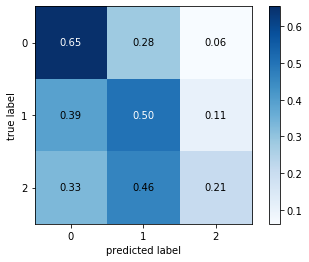

                       importance
LATITUDE                 0.245180
LONGITUDE                0.239670
Population               0.170797
AverageTemperature       0.161137
STAT_CAUSE_DESCR_CODE    0.080654
MONTH                    0.051575
PART_OF_DAY_CODE         0.050987


0.5593225724453482

In [119]:
randomForest(X_train,X_test,y_train,y_test, iv)

Reducing to 2 class labels

# # Sampling after splitting for reduced Class Labels to 2

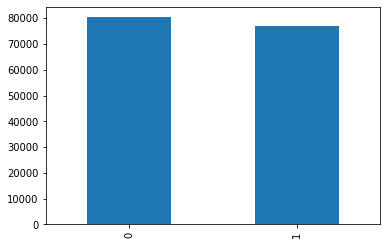

In [120]:
num_df = merged_df.select_dtypes(include=["number"])
# num_df = num_df[num_df.FIRE_SIZE_CLASS_CODE.isin([0,1])]
n =2
num_df.FIRE_SIZE_CLASS_CODE = num_df.FIRE_SIZE_CLASS_CODE.apply(modified_fire_class, n=2)
num_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()
num_df, iv= dropColumns(num_df, n)

In [0]:
y = num_df.FIRE_SIZE_CLASS_CODE # Dependent Variable
X = num_df.drop('FIRE_SIZE_CLASS_CODE', axis=1) # Independent Variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,stratify=y)
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train) 
# X_df = pd.DataFrame(X_train, columns=X.columns)
# y_df = pd.DataFrame(y_train, columns=['FIRE_SIZE_CLASS_CODE'])

# Xt_df = pd.DataFrame(X_test, columns=X.columns)
# yt_df = pd.DataFrame(y_test, columns=['FIRE_SIZE_CLASS_CODE'])


# # a = pd.concat([X_train_df, y_train_df], axis=1)
# # y_train_df.FIRE_SIZE_CLASS_CODE.value_counts().plot.bar()

# X_train = X_df.to_numpy()
# pd.concat([X_df, y_df], axis=1).to_csv('train.csv')
# pd.concat([Xt_df, yt_df], axis=1).to_csv('test.csv')

Accuracy: 0.6101773004575496
              precision    recall  f1-score   support

           0       0.62      0.62      0.62     32131
           1       0.60      0.60      0.60     30813

    accuracy                           0.61     62944
   macro avg       0.61      0.61      0.61     62944
weighted avg       0.61      0.61      0.61     62944



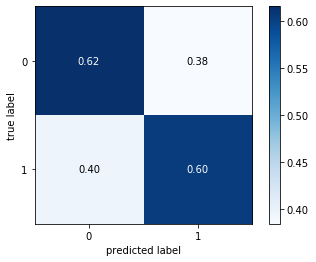

0.6101773004575496

In [122]:
decisionTree(X_train, X_test, y_train, y_test,'balanced')

Accuracy: 0.6414273004575496
              precision    recall  f1-score   support

           0       0.63      0.70      0.67     32131
           1       0.65      0.58      0.61     30813

    accuracy                           0.64     62944
   macro avg       0.64      0.64      0.64     62944
weighted avg       0.64      0.64      0.64     62944



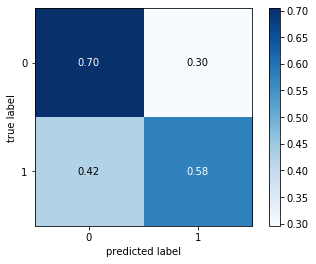

                       importance
LONGITUDE                0.260069
LATITUDE                 0.253242
Population               0.162185
AverageTemperature       0.133082
PART_OF_DAY_CODE         0.076447
STAT_CAUSE_DESCR_CODE    0.065721
MONTH                    0.049253


0.6414273004575496

In [123]:
randomForest(X_train, X_test, y_train, y_test, iv)